<a href="https://colab.research.google.com/github/ammarrahmad/minimising_debts/blob/main/innovation_design.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Debt** Minimization Problem:
Reducing a list of debts among a set of people to the smallest possible number of transfers. This is a common problem for groups of friends or roomates, and the solution is implemented in various apps and websites, such as Splitwise, Tricount, and others.
# Problem Statement

"""
Consider a group of n participants P = {P1, P2, ..., Pn}, where each participant may either owe or be owed money by one or more other participants.
Let d_ij denote the debt amount that participant P_i owes to participant P_j.
The debts d_ij form a directed weighted graph G = (P, E), where E is the set of directed edges,
and the weight of edge e_ij ∈ E is the amount d_ij.

The goal is to restructure the debt relationships to minimize:
1. The total number of transactions (the number of edges — #d where d_ij != 0) in the new graph AND/OR
2. The total transaction volume (sum of all the weights of edges - Σ d_ij) in the new graph

This restructuring is required to settle all debts while ensuring that each participant's net balance remains unchanged.
Specifically, we seek to find a new graph G' = (P, E') such that the net balance for each person is preserved.
"""

<!-- {% include mathjax.html %} -->

To make this work, we make the assumption that debt is transferable, that is, if A owes \\$5 to B, and B owes \\$5 to C, we can convert this into a single \\$5 transfer from A to C.

We first prove that the problem is NP complete, but we can get a solution with at most (number of people) - 1 transfers in linear time in the number of transactions.

## A simple solution

There is a straightforward solution that is linear in \{number of transactions + number of people\}.

Let's start with a set of people and debts. We'll take the convention that `("Laksh", "Kushal", 5)` means Grace owes Kushal \\$5. We call Grace the _debtor_ and Kushal the _creditor_.

In [1]:
people = ["Laksh", "Kushal", "Anand", "Yash", "Kanishk"]
debts = [
    ("Laksh", "Kushal", 5),
    ("Laksh", "Anand", 3),
    ("Kushal", "Laksh", 2),
    ("Kushal", "Kanishk", 5),
    ("Anand", "Laksh", 10),
    ("Anand", "Yash", 4),
    ("Anand", "Kanishk", 6),
    ("Anand", "Kanishk", 2),
    ("Yash", "Kushal", 4),
    ("Kanishk", "Laksh", 15),
    ("Kanishk", "Yash", 6),
    ("Kanishk", "Anand", 11),
]
len(debts)

12

Next, let's compute everybody's balance. The balance is the net amount of money someone must receive from all other members of the group (it can be negative if the person is a net debtor). Any set of transactions we come up \\with must preserve everybody's balance. In fact, a set of transaction is correct _if and only if_ it does so: everybody must pay or receive as much money as they owed or were owed initially, and this is the only constraint on the solution we must pick.

Since there is no debt going in or out of the group as a whole, the sum of everybody's balances must be 0.

In [19]:
!pip install pulp

In [20]:
def compute_balances(debts):
    balances = {person: 0 for person in people}
    for (debtor, creditor, value) in debts:
        balances[debtor] -= value
        balances[creditor] += value
    return balances
compute_balances(debts)

{'Laksh': 19, 'Kushal': 2, 'Anand': -8, 'Yash': 6, 'Kanishk': -19}

Once we have balances, we can pick someone at random who we'll call the _collector_ (let's take Grace as an example). Everybody with a negative balance will pay Grace for their total debt amount (to everybody in the group, not just Grace), and Grace will pay everybody with a positive balance for their total credit amount. We don't include any other transactions in our solution set.

Clearly, everybody who isn't Grace has their balance preserved: they have a single transaction for their balance amount. What about Grace herself?

We know that the total balance of the group is 0, so Grace's balance must be the opposite of the sum of everybody else's balance, or, denotig each person's balance as $b_p$,

$$
b_\mathrm{Grace} = -\sum_{p\in\mathrm{group},\, p\neq\mathrm{Grace}} b_p.
$$

But $-\sum_{p\in\mathrm{group},\, p\neq\mathrm{Grace}} b_p$ is exactly the net amount of money Grace is receiving, because she has one transaction for each other person in the group, worth exactly their balance.

In sum, this solution satisfies our balance constraints, so it's an allowable way for the group to resolve their debts. There are $n - 1$ transactions at most (there may be fewer if anybody's balance is exactly 0), where _n_ is the number of people in the group: one for each person, except for the collector.

In [21]:
def simplify_with_collector(balances):
    collector = next(iter(balances.keys()))
    return [(collector, person, balance) for (person, balance)
            in balances.items() if person != collector]

def show_transactions(transactions):
    for (debtor, creditor, value) in transactions:
        if value > 0:
            print(f"{debtor} owes {creditor} ${value}")
        else:
            print(f"{creditor} owes {debtor} ${-value}")

collector_transactions = simplify_with_collector(compute_balances(debts))
show_transactions(collector_transactions)

Laksh owes Kushal $2
Anand owes Laksh $8
Laksh owes Yash $6
Kanishk owes Laksh $19


With the [NetworkX](https://networkx.github.io/) library and [matplotlib](https://matplotlib.org/), we can easily view the result as graph. Looking at graphs will be useful later, so let's introduce this now:

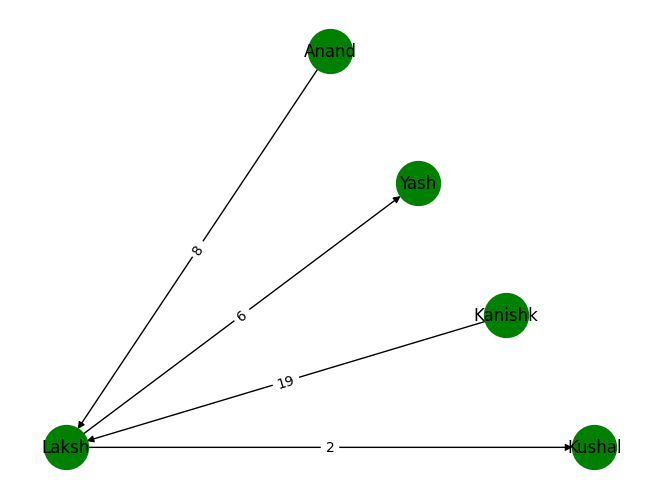

In [22]:
import networkx as nx
G = nx.DiGraph()
G.add_nodes_from(people)
G.add_weighted_edges_from(collector_transactions)

# Some of the graphs we make have edges with negative values, which
# is confusing. This function just inverts the direction of all
# negative-valued edges.
def reorient_digraph(G):
    NG = nx.DiGraph()
    NG.add_nodes_from(G.nodes)
    for (start, end) in G.edges:
        weight = G[start][end]['weight']
        if weight > 0:
            NG.add_edge(start, end, weight=weight)
        else:
            NG.add_edge(end, start, weight=-weight)
    return NG

def print_digraph(G, pos):
    nx.draw(G, pos, with_labels=True, node_color='g', node_size=1000)
    labels = nx.get_edge_attributes(G, 'weight')
    _ = nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

print_digraph(reorient_digraph(G), nx.planar_layout(G))

This solution's complexity is $O(m + n)$, where _m_ is the number of initial debts we consider, and _n_ is the number of people; the only real work is to go over the _m_ debts and compute balances, then add _n_ transactions.

In practice, this solution is pretty good: it's fast to compute, and each person except the collector has at most 1 transaction to make. On the other hand, the collector is part of $n - 1$ transactions, which can be a lot.

### Optimality of the linear-time solution

There are sets of initial debts that can never be resolved in less than $n - 1$ transactions (one instance is when everybody has a balance of -1, except for one person who has a balance of _n_)[^1]. So there are at least some cases for which our algorithm gives the optimal answer.

[^1]: Exercise for the reader: prove this example really cannot be solved in fewer transactions.

However, there are also cases where this is not optimal at all. Consider a set of $2k$ friends, where half of the people have a balance of -1, and the other half have a balance of 1. Our algorithm would result in $2k - 1$ transactions, but these debts can be resolved in _k_ transfers by pairing each debtor with a creditor.

So just how bad is our algorithm doing? Well, each person with a nonzero balance will have to make at least one transaction. A transaction involves exactly two people, so if there are _n_ people, there must be at least $n/2$ transactions. Our linear-time algorithm can easily exclude people with a 0 balance as well and still run in linear time, so we end up with $n-1$ versus $n/2$: the linear-time algorithm is at most a factor of 2 off.

Unfortunately, finding the optimal solution is an NP-complete problem.

## An optimal solution

First, let's characterize the cases when we can go below $n - 1$ transactions. Let's consider a graph of the various transactions at play, where the nodes are people, and the edges are transactions.

Any graph with $n$ points and less than $n - 1$ edges can't be connected, so if there are less than $n - 1$ transactions, there must be at least two separate components to the graph in our optimal solution. Equivalently, there must be two subgroups of people who can fully settle their debts internally. Each such subgroup must have an aggregate balance of 0, otherwise this subgroup as a whole would owe money to the rest of the people, and we would have to add transactions connecting it to the rest of the group.

In fact, if we have $n - k$ total transactions for some _k_, we must have exactly _k_ connected components in the graph, and each component must have a balance of 0.

So the optimal solution is to find as many disjoint subgroups of people as possible whose total balance is 0, then treat each subgroup as a separate problem, applying the linear solution above.

Let's start by finding all subsets of people whose aggregate balance is 0. This part is basically the [subset sum](https://en.wikipedia.org/wiki/Subset_sum_problem) problem, which [is NP-complete](https://www.cs.cornell.edu/courses/cs4820/2018fa/lectures/subset_sum.pdf). I'm fully brute-forcing it here; there are usually ways to optimize some parts of this type of problem, but I can't be bothered.

In [24]:
import itertools

def find_zero_subset(balances):
    for i in range(1, len(balances)):
        for subset in itertools.combinations(balances.items(), i):
            if sum([balance[1] for balance in subset]) == 0:
                return [balance[0] for balance in subset]
    return None

remaining_set = compute_balances(debts)
subsets = []
while (subset := find_zero_subset(remaining_set)) is not None:
    subsets.append(subset)
    remaining_set = {x[0]: x[1] for x in remaining_set.items() if x[0] not in subset}
subsets.append(list(remaining_set.keys()))
subsets

[['Laksh', 'Kanishk'], ['Kushal', 'Anand', 'Yash']]

We have two subgroups, so we can expect $(n - 1) - (2 - 1) = n - 2 = 3$ transactions in the final solution. We can now apply the solution from the previous section to each subgroup:

In [25]:
balances = compute_balances(debts)
optimal_transactions = []
for subset in subsets:
    subset_balances = {person: balances[person] for person in subset}
    optimal_transactions.extend(simplify_with_collector(subset_balances))
show_transactions(optimal_transactions)

Kanishk owes Laksh $19
Anand owes Kushal $8
Kushal owes Yash $6


What does this look like as a graph?

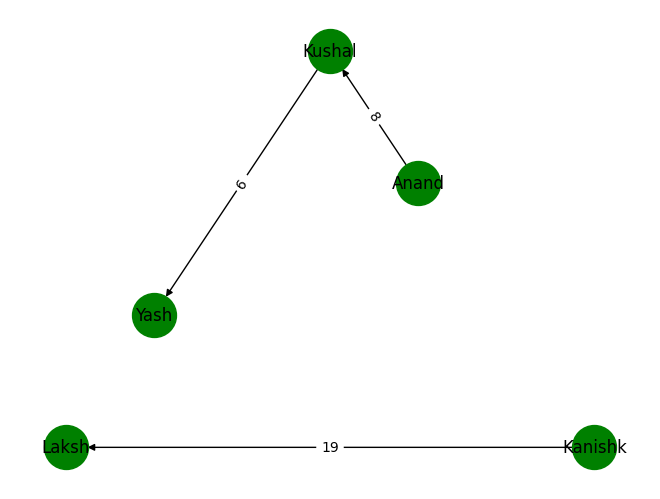

In [26]:
SG = nx.DiGraph()
SG.add_nodes_from(people)
SG.add_weighted_edges_from(optimal_transactions)
print_digraph(reorient_digraph(SG), nx.planar_layout(SG))

We can clearly see the two connected components.

## Variant 1: Minimizing the amount of money transferred

Let's finish with two alternative ways to solve the approximated problem.

The first variant still gets $n - 1$ transactions, but also minimizes the total amount of money transfered between people. This might be the best solution if some proportional fee must be paid for each transfer.

Once again, let's think about what a solution must look like. We know that each person with a positive balance will have to be involved in transactions totaling at least the value of their balance, in order to return to 0. Returning to our previous notation, the best we can hope to do is to have a total transaction value of

$$
\sum_{p\in\mathrm{group},\,b_p>0} b_p.
$$

In fact, we can always achieve this. We can divide the group between net creditors and net debtors, and add transactions from each debtor to as many creditors as it takes to reduce the debt to 0. The following algorithm achieves this:

In [28]:
import random

def simplify_minflow(debts):
    balances = compute_balances(debts)
    transactions = []
    debtors = {p: b for (p, b) in balances.items() if b < 0}
    creditors = {p: b for (p, b) in balances.items() if b > 0}

    while debtors:
        (debtor, debt) = next(iter(debtors.items()))
        (creditor, credit) = next(iter(creditors.items()))
        amount = min(-debt, credit)
        transactions.append((debtor, creditor, amount))

        creditors[creditor] -= amount
        debtors[debtor] += amount
        if creditors[creditor] == 0:
            del creditors[creditor]
        if debtors[debtor] == 0:
            del debtors[debtor]

    return transactions

minflow_transactions = simplify_minflow(debts)
show_transactions(minflow_transactions)

Anand owes Laksh $8
Kanishk owes Laksh $11
Kanishk owes Kushal $2
Kanishk owes Yash $6


Looking at the graph, we can see it's [bipartite](https://mathworld.wolfram.com/BipartiteGraph.html): each node has either only outgoing transactions (if it has a starting negative balance), or only incoming transactions (if the starting balance is positive). This is the case for all optimal graphs: as soon as a single person has both inbound and outbound transactions, we know there must be wasted effort, as some of these transactions will bring the person further from a 0 balance.

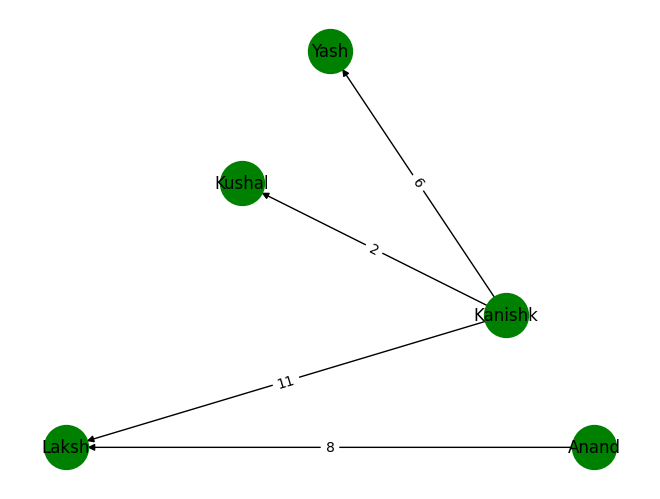

In [29]:
import networkx as nx
G = nx.DiGraph()
G.add_nodes_from(people)
G.add_weighted_edges_from(minflow_transactions)
print_digraph(reorient_digraph(G), nx.planar_layout(G))

This algorithm is also optimal from a number-of-transactions perspective. During each iteration of the loop, we create one transaction and we remove at least one creditor or one debtor by reducing their balance to 0. During the last iteration, we are guaranteed to remove the last creditor *and* the last debtor. Overall, we once again create at most $n - 1$ transactions.

### Complexity

Much like the first solution, this is $O(m + n)$: we need to compute balances in $O(m)$, then create at most $n - 1$ transactions in $O(n)$ total.

## Variant 2: No new transactions

This first algorithm also gives at most $n - 1$ transactions in a graph, but with the added constraint that it will never create a transaction between two people who do not have a debt to start with. This can be advantageous in large groups, if we want to avoid designating a collector who will have a lot of work to do.

First, we'll tidy up the list of debts:
 - We convert all debt so that the debtor comes before the creditor, alphabetically. The debt may become negative as a result. This is a technical trick that will make our life easier later on.
 - We group together all debt owed by the same debtor to the same creditor.
 - We remove any 0-valued debt, or debt whith the same creditor and debtor.

In [30]:
def order_debt(debt):
    debtor, creditor, value = debt
    if debtor < creditor:
        return debt
    else:
        return (creditor, debtor, -value)

def filter_debt(debt):
    debtor, creditor, value = debt
    return value != 0 and debtor != creditor

def tidy_debts(debt_list):
    ordered = sorted([order_debt(d) for d in debt_list if order_debt(d) is not None])
    grouped = itertools.groupby(ordered, lambda debt: (debt[0], debt[1]))
    summed = [(key[0], key[1], sum([d[2] for d in debts])) for (key, debts) in grouped]
    return [d for d in summed if filter_debt(d)]

summed = tidy_debts(debts)
summed

[('Anand', 'Kanishk', -3),
 ('Anand', 'Laksh', 7),
 ('Anand', 'Yash', 4),
 ('Kanishk', 'Kushal', -5),
 ('Kanishk', 'Laksh', 15),
 ('Kanishk', 'Yash', 6),
 ('Kushal', 'Laksh', -3),
 ('Kushal', 'Yash', -4)]

Let's take a look at the resulting debt graph:

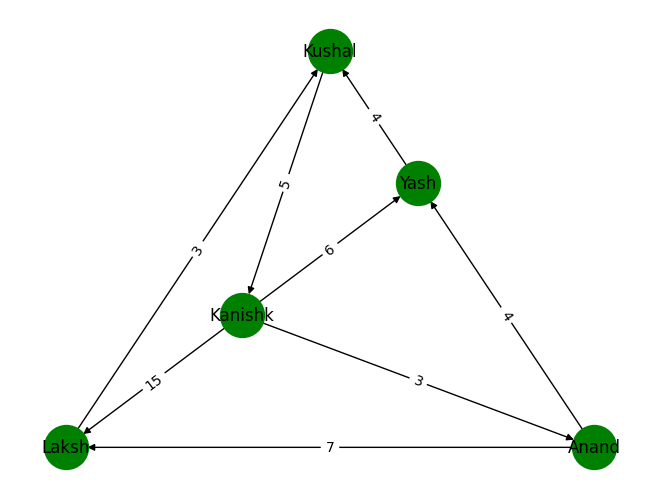

In [31]:
import networkx as nx
G = nx.DiGraph()
G.add_nodes_from(people)
G.add_weighted_edges_from(summed)
pos = nx.planar_layout(G)
print_digraph(reorient_digraph(G), pos)

Next, ignoring the direction of the arrows (i.e. treating the graph as undirected), consider any cycle in the graph, for instance Grace - Ivan - Luke - Mallory. The key insight is that if we add a new set of debts, all for the same amount and in the same direction, between the members of the cycle, nobody's balance will change. This is true because each person will receive a new credit from the person preceding them in the cycle, and incur a new debt for the same value to the person following them in the cycle, for a net change of 0.

For instance, Yash - Kushal - Kanishk - Anand is a cycle; if we ask Yash to give Kushal \\$4, Kushal to give Kanishk \\$4, Kanishk to give Anand \\$4, and Anand to give Yash \\$4, in addition to all existing debts, nobody's balance has changed.

Also note that given a cycle, we can chose the amount and direction of the debt we add to exactly cancel out any one of the edges in the cycle. So by picking the amount and direction intelligently, we can remove one edge from any cycle without adding any new edges.

So this is the core idea of the algorithm: keep breaking cycles one by one, until there aren't any left.

After adjusting ['Kushal', 'Yash', 'Anand', 'Kanishk'] by -4:


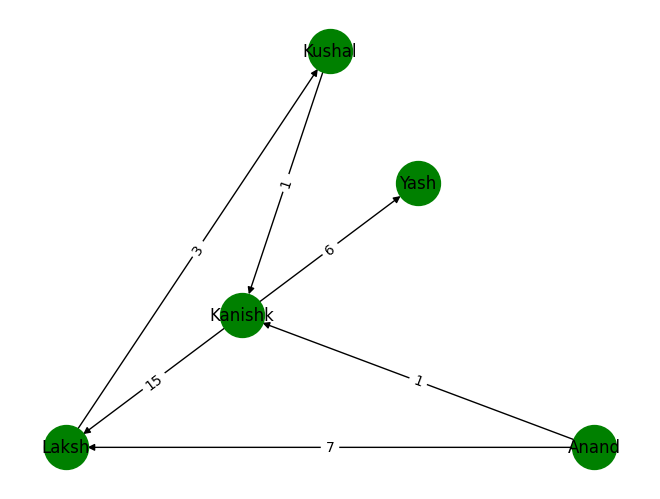

After adjusting ['Laksh', 'Kushal', 'Kanishk', 'Anand'] by 3:


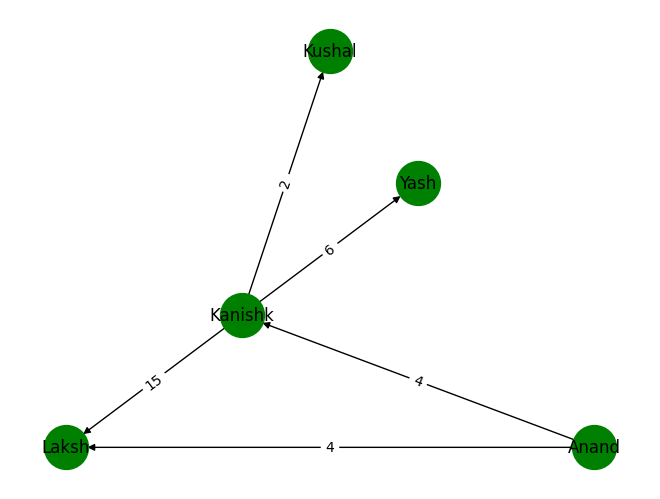

After adjusting ['Laksh', 'Anand', 'Kanishk'] by -4:


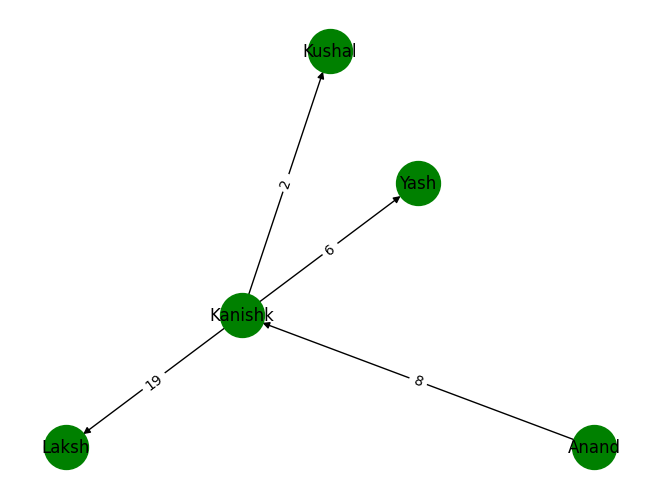

In [32]:
import matplotlib.pyplot as plt

def edge_inverter(edge):
    if edge[0] < edge[1]:
        return (1, (edge[0], edge[1]))
    else:
        return (-1, (edge[1], edge[0]))

def simplify_transactions(G, show_details=False):
    G = G.copy()
    while True:

        # 1 - find a cycle
        try:
            cycle = nx.algorithms.cycles.find_cycle(G.to_undirected())
        except nx.exception.NetworkXNoCycle:
            break

        # 2 - pick an arbitrary edge, e.g. the first one, and select its amount
        #     (amount_to_remove) and direction (inverted)
        inverted, edge_to_remove = edge_inverter(cycle[0])
        amount_to_remove = G[edge_to_remove[0]][edge_to_remove[1]]['weight'] * inverted

        # 3- iterate through nodes in the cycle and subtract (or add, depending
        #    on the edge's direction) the amount in question. Delete any edges that
        #    end up with 0 weight.
        for edge in cycle:
            inverter, edge = edge_inverter(edge)
            G[edge[0]][edge[1]]['weight'] -= amount_to_remove * inverter
            if G[edge[0]][edge[1]]['weight'] == 0:
                G.remove_edge(edge[0], edge[1])

        if show_details:
            print(f"After adjusting {[n[0] for n in cycle]} by {amount_to_remove}:")
            print_digraph(reorient_digraph(G), pos)
            plt.show()

    return G

simplified = simplify_transactions(G, show_details=True)

(`edge_inverter` just deals with the fact that we should reverse a debt if the edge is going backwards).

And we're done! We've gotten lucky and ended up with $n - 2$ transactions (we could have gotten $n - 1$ instead), as a strict subset of the original set of debts.

In [33]:
def to_transactions(graph):
    transactions = []
    for edge in graph.edges:
        inverter, (node1, node2) = edge_inverter(edge)
        owed = simplified[node1][node2]['weight'] * inverter
        transactions.append((node1, node2, owed))
    return transactions

show_transactions(to_transactions(simplified))

Anand owes Kanishk $8
Kanishk owes Kushal $2
Kanishk owes Laksh $19
Kanishk owes Yash $6


In [34]:
# Index Mapping
nameList = ["Greedy", "Linear Programming", "Closest Match", "Auction based", "Randomised rounding", "Network Flow", "LPusingPulp"]
FinalTranny = []

In [35]:
!pip install sortedcontainers

## Making the networkx functions workable

In [36]:
import networkx as nx

# Initialize the directed graph
G = nx.DiGraph()

# Modify the add_weighted_edge function to handle same and opposite directions
def add_weighted_edge(G, u, v, weight):
    if G.has_edge(u, v):
        # If the edge exists in the same direction, add the weight
        G[u][v]['weight'] += weight
    elif G.has_edge(v, u):
        # If the edge exists in the opposite direction, subtract the weight
        G[v][u]['weight'] -= weight
        # Remove the edge if the weight becomes zero
        if G[v][u]['weight'] == 0:
            G.remove_edge(v, u)
    else:
        # If the edge doesn't exist, add it with the given weight
        G.add_edge(u, v, weight=weight)

# Function to reorient edges based on positive/negative weights
def reorient_digraph(G):
    NG = nx.DiGraph()
    NG.add_nodes_from(G.nodes)
    for (start, end) in G.edges:
        weight = G[start][end]['weight']
        if weight > 0:
            NG.add_edge(start, end, weight=weight)
        else:
            NG.add_edge(end, start, weight=-weight)
    return NG

# Function to print the directed graph with edge labels
def print_digraph(G, pos):
    nx.draw(G, pos, with_labels=True, node_color='g', node_size=1000)
    labels = nx.get_edge_attributes(G, 'weight')
    _ = nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

## Our Code

Most Optimal using maximum zero sum subsets

Enter the number of people (n): 10
Enter the number of transactions (m): 12

Transactions (i, j, w):
[(5, 6, 9), (3, 7, 5), (7, 1, 8), (7, 1, 4), (7, 9, 8), (6, 8, 7), (6, 2, 7), (2, 6, 6), (4, 1, 10), (7, 8, 1), (4, 2, 7), (5, 4, 8)]

Final Balance Array:
[-22, -8, 5, 9, 17, -1, 16, -8, -8, 0]


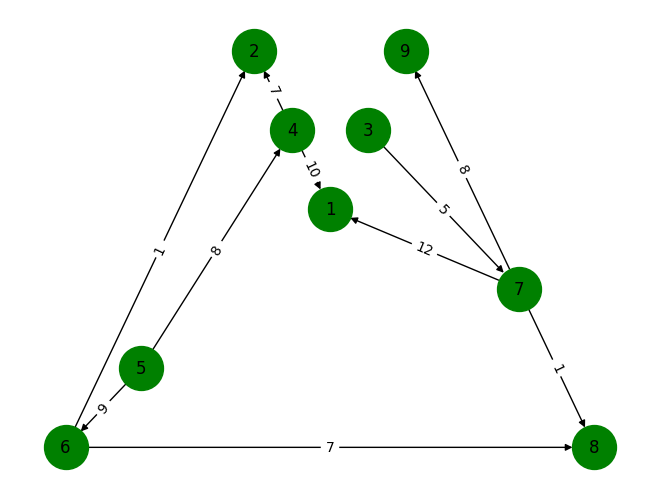

In [37]:
import heapq
import random
from itertools import combinations

def generate_test_cases(n, m):
    # Initialize map to store the balance changes
    mp = {i: 0 for i in range(n)}

    # List to store the transactions
    transactions = []
    for _ in range(m):
        # Generate two different random numbers i and j
        i, j = random.sample(range(n), 2)
        # i = int(input("Enter person1: "))
        # j = int(input("Enter person2: "))

        # Generate random weight w
        w = random.randint(1, 10)

        # w = int(input("Enter cost: "))
        # Save transaction (i, j, w) to the list
        # transactions.append((nameList[i], nameList[j], w))
        transactions.append((i+1, j+1, w))
        # Update map
        mp[i] += w
        mp[j] -= w
    # Convert the map to an array
    balance_array = [mp[i] for i in range(n)]

    return transactions, balance_array


# Take input from user
n = int(input("Enter the number of people (n): "))
m = int(input("Enter the number of transactions (m): "))

# Generate test cases
transactions, balance_array = generate_test_cases(n, m)

print("\nTransactions (i, j, w):")
# for transaction in transactions:
#     print(transaction)

print(transactions)

print("\nFinal Balance Array:")
print(balance_array)

people1 = []
for i in range(1, n+1):
  people1.append(i)


G = nx.DiGraph()
# G.add_nodes_from(people1)
# G.add_weighted_edges_from(transactions)
# pos = nx.planar_layout(G)
# print_digraph(reorient_digraph(G), pos)

# Add nodes and edges with the custom function
for (u, v, w) in transactions:
    add_weighted_edge(G, u, v, w)


# Get positions for drawing and print the directed graph
pos = nx.planar_layout(G)
print_digraph(reorient_digraph(G), pos)


arr2 = []
ind = 1

for i in balance_array:
    arr2.append((i, ind))
    ind += 1

Printing the balanced array mapped to the person [(-22, 1), (-8, 2), (5, 3), (9, 4), (17, 5), (-1, 6), (16, 7), (-8, 8), (-8, 9), (0, 10)]
Max zero-sum partition:
((16, 7), (-8, 8), (-8, 9))
((-8, 2), (9, 4), (-1, 6))
((-22, 1), (5, 3), (17, 5))
((0, 10),)
SortedList([(-8, 8), (-8, 9), (16, 7)])
SortedList([(-8, 2), (-1, 6), (9, 4)])
SortedList([(-22, 1), (5, 3), (17, 5)])
SortedList([(0, 10)])
Transactions:  [[7, 8, 8], [7, 9, 8], [4, 2, 8], [4, 6, 1], [5, 1, 17], [3, 1, 5]]
Total number of Partitions with sum zero:  4
Total number of transactions:  6
Total(also minimum) cash flow:  47


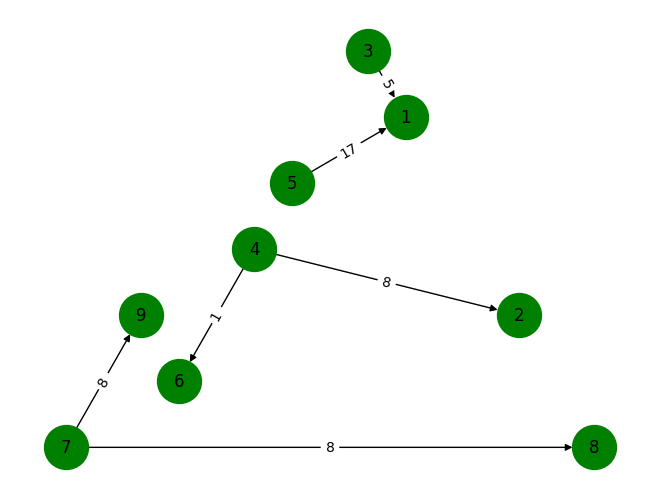

In [38]:
from sortedcontainers import SortedList

# Utility function to check if a subset has sum zero
def is_zero_sum(subset):
    sum1 = 0
    for x, y in subset:
        sum1 += x
    return sum1 == 0

# Function to generate zero-sum subsets dynamically
def find_zero_sum_subsets(arr):
    zero_sum_subsets = []
    n = len(arr)

    # Generate all possible subsets
    for subset_size in range(1, n + 1):
        for subset in combinations(arr, subset_size):
            if is_zero_sum(subset):
                zero_sum_subsets.append(subset)
    return zero_sum_subsets


# A* Search to find the maximum number of zero-sum subsets
def max_zero_sum_partition(arr):
    memo = {}
    n = len(arr)

    # Priority queue to implement A* search (min-heap)
    # Each element in the heap is a tuple (cost, number of zero-sum subsets, remaining elements, current partition)
    heap = []

    # Initial state: No partitions, all elements remaining
    heapq.heappush(heap, (0, 0, tuple(arr), []))
    best_partition = []

    while heap:
        # Pop the state with the lowest cost (A* prioritizes lowest cost)
        cost, zero_sum_count, remaining, current_partition = heapq.heappop(heap)

        # If this state has been visited, skip it
        if remaining in memo and memo[remaining] >= zero_sum_count:
            continue

        # Memoize the current state
        memo[remaining] = zero_sum_count

        # If no elements are remaining, we've found a valid partition
        if not remaining:
            if zero_sum_count > len(best_partition):
                best_partition = current_partition
            continue

        # Generate all possible zero-sum subsets from the remaining elements
        zero_sum_subsets = find_zero_sum_subsets(remaining)

        for subset in zero_sum_subsets:
            # Remove the subset elements from remaining and create the next state
            new_remaining = list(remaining)
            for el in subset:
                new_remaining.remove(el)
            new_remaining = tuple(new_remaining)

            # New partition includes this subset
            new_partition = current_partition + [subset]

            # Add the new state to the heap with updated cost and heuristic
            heapq.heappush(heap, (len(new_remaining), zero_sum_count + 1, new_remaining, new_partition))

    return best_partition

# Example usage
# arr = [24, 0, -110, 44, -35, 71, 10, 58, 40, -102]
# l = random.sample(range(-10, 10), k=4)
# arr = l + [-sum(l)]

print("Printing the balanced array mapped to the person", arr2)
partition = max_zero_sum_partition(arr2)
# Printing each partition as a separate array
print("Max zero-sum partition:")
for subset in partition:
    print(subset)
# print(list(subset), end=":  ") # Convert each tuple to a list before printing
# print("Total number of Transactions for this subset is ", len(subset)-1)


sum1 = 0
tranny = []
for subset in partition:
    st = SortedList(subset)
    print(st)
    while len(st) > 1:
        top = st[0]  # Smallest element
        bottom = st[-1]  # Largest element
        st.pop(0)  # Remove the smallest element
        st.pop(-1)  # Remove the largest elemen
        tranny.append([bottom[1], top[1], min(abs(bottom[0]), abs(top[0]))])
        sum1 += min(abs(bottom[0]), abs(top[0]))
        if abs(bottom[0]) > abs(top[0]):
            st.add((abs(bottom[0]) - abs(top[0]), bottom[1]))
        elif abs(bottom[0]) < abs(top[0]):
            st.add((abs(bottom[0]) - abs(top[0]), top[1]))


print("Transactions: ", tranny)

si = len(partition)
finMini = n-si
print("Total number of Partitions with sum zero: ", si)
print("Total number of transactions: ", n-si)
print("Total(also minimum) cash flow: ", sum1)
G = nx.DiGraph()
# G.add_nodes_from(people1)
# Add nodes and edges with the custom function
for (u, v, w) in tranny:
    add_weighted_edge(G, u, v, w)

# Get positions for drawing and print the directed graph
pos = nx.planar_layout(G)
print_digraph(reorient_digraph(G), pos)

# Heuristics: Maximum Pair Match Algorithm:
Matching the greatest debt with the greatest credit.

*   Approach: Match the largest creditor with the largest debtor in each iteration. Adjust the debts accordingly and repeat until all debts are settled.
*   Pros: Simple and effective in many cases.
*   Cons: May not always yield the minimum number of transactions.
Time Complexity is O(nlogn) where n is the number of people.



Total number of transactions:  6
Total(also minimum) cash flow:  47


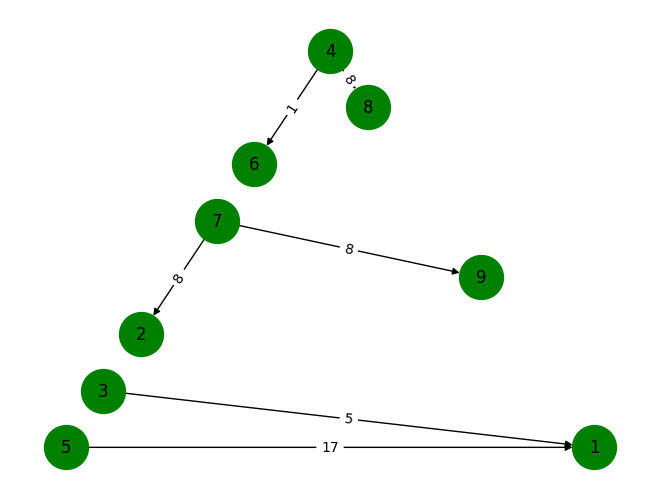

In [39]:
def maxpairmatch(set3):
  sum2 = 0
  cnt = 0
  tranny2 = []
  while len(set3) > 1:
      cnt += 1
      top = set3[0]  # Smallest element
      bottom = set3[-1]  # Largest element
      set3.pop(0)  # Remove the smallest element
      set3.pop(-1)  # Remove the largest elemen
      tranny2.append([bottom[1], top[1], min(abs(bottom[0]), abs(top[0]))])
      sum2 += min(abs(bottom[0]), abs(top[0]))
      if abs(bottom[0]) > abs(top[0]):
          set3.add((abs(bottom[0]) - abs(top[0]), bottom[1]))
      elif abs(bottom[0]) < abs(top[0]):
          set3.add((abs(bottom[0]) - abs(top[0]), top[1]))
  return tranny2, sum2, cnt

arrf = [pair for pair in arr2 if pair[0] != 0]
set3 = SortedList(arrf)
tranny2, sum2, cnt = maxpairmatch(set3)

print("Total number of transactions: ", cnt)
print("Total(also minimum) cash flow: ", sum2)

G = nx.DiGraph()
# G.add_nodes_from(people1)
# Add nodes and edges with the custom function
for (u, v, w) in tranny2:
    add_weighted_edge(G, u, v, w)

# Get positions for drawing and print the directed graph
pos = nx.planar_layout(G)
print_digraph(reorient_digraph(G), pos)

FinalTranny.append(cnt)


# Heuristics: Linear Programming Algorithm:


*   Approach: Use a linear programming solver to approximate minimise the total transaction volume therefore also find closely optimal minimal transactions.
Define a variable for each possible transaction.
Set constraints to ensure that all debts are settled.
Minimize the number of non-zero transactions.
*   Pros: Can get close to the theoretical minimum.
*   Cons: Computationally intensive for very large groups.

Time Complexity is O(n^3) where n is the number of people.


Transactions: [(4, 1, 5.0), (5, 1, 17.0), (7, 2, 8.0), (7, 8, 8.0), (3, 9, 4.0), (4, 9, 4.0), (3, 6, 1.0)]
Total number of transactions:  7


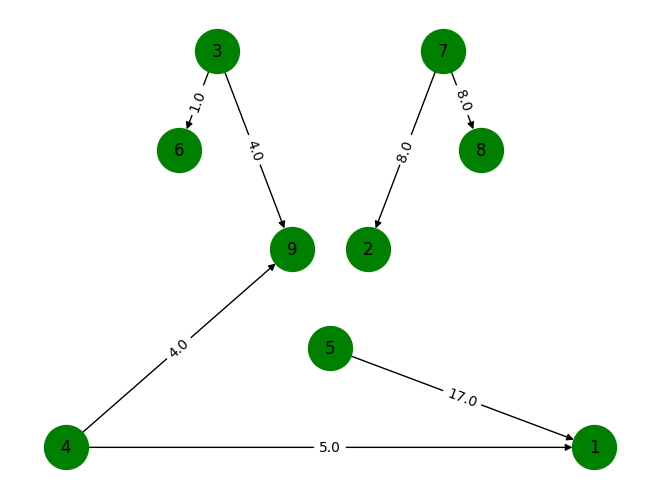

In [40]:
import numpy as np
from scipy.optimize import linprog

def linear_programming_approximation(balances):
    """
    Minimize debts using a linear programming approximation.
    :param balances: List of tuples representing balances (amount, person_number).
    :return: List of transactions to settle debts.
    """
    n = len(balances)
    people = [person for _, person in balances]
    net_balances = np.array([amount for amount, _ in balances])

    # Define variables: transaction[i][j] is the amount paid from person i to person j
    num_variables = n * n
    c = np.ones(num_variables)  # Minimize total transaction amounts
    A_eq = np.zeros((n, num_variables))
    b_eq = -net_balances

    # Constraints to ensure net balance is satisfied for each person
    for i in range(n):
        for j in range(n):
            A_eq[i][i * n + j] = 1  # Outflow from person i
            A_eq[i][j * n + i] = -1  # Inflow to person i

    # Bounds: transaction amounts are non-negative
    bounds = [(0, None) for _ in range(num_variables)]

    # Solve the linear program
    result = linprog(c, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method='highs')

    if not result.success:
        raise ValueError("Linear programming failed to find a solution.")

    # Extract transactions
    transactions = []
    x = result.x.reshape((n, n))
    for i in range(n):
        for j in range(n):
            if x[i][j] > 1e-6:  # Ignore negligible amounts
                transactions.append((people[j], people[i], round(x[i][j], 2)))

    return transactions


# Example usage
set5 = SortedList(arr2)


transactions = linear_programming_approximation(set5)
print("Transactions:", transactions)
FinalTranny.append(len(transactions))
print("Total number of transactions: ", len(transactions))
# print("Total(also minimum) cash flow: ", sum2)

G = nx.DiGraph()
# G.add_nodes_from(people1)
# Add nodes and edges with the custom function
for (u, v, w) in transactions:
    add_weighted_edge(G, u, v, w)

# Get positions for drawing and print the directed graph
pos = nx.planar_layout(G)
print_digraph(reorient_digraph(G), pos)

# Heuristics: Closest Match Algorithm:


*   Approach: Finding a closest match creditor for an equivalent debt amount
Set constraints to ensure that all debts are settled.
*   Pros: Can get close to the theoretical minimum.
*   Cons: Computationally intensive for very large groups.

The time complexity of the closest_match_heuristic function is O(n^2 log n)

Transactions: [(3, 2, 5), (4, 8, 8), (4, 6, 1), (7, 1, 16), (5, 9, 8), (5, 1, 6), (5, 2, 3)]
Total number of transactions:  7


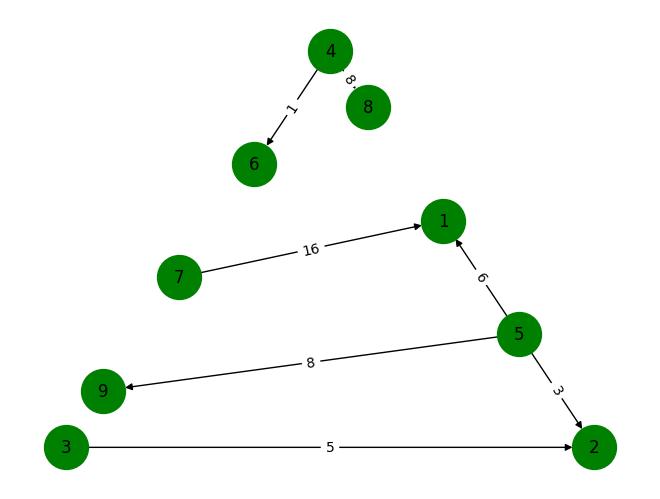

In [41]:
def closest_match_heuristic(balances):
    """
    Heuristic to minimize transactions by matching creditors to closest debtors.

    Args:
    - balances: List of tuples, where each tuple is (amount, person_number).
      Positive amounts represent creditors, negative amounts represent debtors.

    Returns:
    - List of transactions as tuples (debtor, creditor, amount).
    """
    # Separate creditors and debtors
    debtors = [(abs(amount), person) for amount, person in balances if amount < 0]
    creditors = [(amount, person) for amount, person in balances if amount > 0]

    transactions = []

    while creditors and debtors:
        # Sort creditors and debtors to find closest matches
        creditors.sort(key=lambda x: x[0])  # Smallest creditor first
        debtors.sort(key=lambda x: x[0])    # Smallest debtor first

        # Pick the smallest creditor
        credit_amount, creditor = creditors.pop(0)

        # Find the closest debtor for -credit_amount
        closest_match = None
        min_diff = float('inf')
        closest_index = -1

        for i, (debt_amount, debtor) in enumerate(debtors):
            diff = abs(debt_amount - credit_amount)
            if diff < min_diff:
                min_diff = diff
                closest_match = (debt_amount, debtor)
                closest_index = i

        if closest_match:
            debt_amount, debtor = closest_match
            transfer_amount = min(credit_amount, debt_amount)

            # Record the transaction
            transactions.append((creditor, debtor, transfer_amount))

            # Update balances
            debtors[closest_index] = (debt_amount - transfer_amount, debtor)
            if debtors[closest_index][0] == 0:
                debtors.pop(closest_index)

            if credit_amount > transfer_amount:
                creditors.append((credit_amount - transfer_amount, creditor))

    return transactions


# Example usage
set6 = SortedList(arr2)

transactions = closest_match_heuristic(set6)
print("Transactions:", transactions)
FinalTranny.append(len(transactions))
print("Total number of transactions: ", len(transactions))
# print("Total(also minimum) cash flow: ", sum2)

G = nx.DiGraph()
# G.add_nodes_from(people1)
# Add nodes and edges with the custom function
for (u, v, w) in transactions:
    add_weighted_edge(G, u, v, w)

# Get positions for drawing and print the directed graph
pos = nx.planar_layout(G)
print_digraph(reorient_digraph(G), pos)

# Heuristics: Auction Based Approximation:


*   Approach: The Auction-Based Approximation algorithm uses the concept of an auction to match debtors and creditors efficiently. In this method, debtors "bid" to pay off creditors based on their available balances, and creditors "choose" the highest bidder. The process continues iteratively until all debts are settled.
*   Pros: Simple to implement, flexible, and efficient for small groups without requiring advanced solvers.
*   Cons: Suboptimal results and inefficient for large datasets due to repeated sorting and heuristic matching.

The time complexity of the closest_match_heuristic function is O(n^3)

Transactions: [(5, 1, 17), (7, 1, 5), (7, 2, 8), (7, 8, 3), (4, 8, 5), (4, 9, 4), (3, 9, 4), (3, 6, 1)]
Total number of transactions:  8


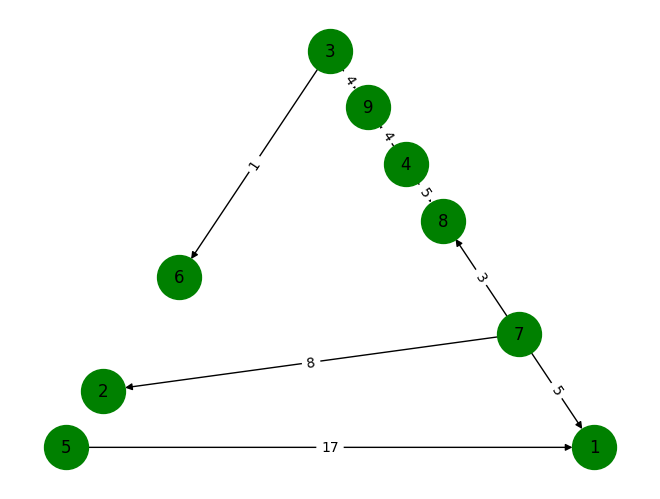

In [42]:
def auction_based_approximation(balances):
    """
    Minimize debts using auction-based approximation.
    :param balances: List of tuples representing balances (amount, person_number).
    :return: List of transactions to settle debts.
    """
    creditors = [(amount, person) for amount, person in balances if amount > 0]
    debtors = [(amount, person) for amount, person in balances if amount < 0]

    transactions = []

    while debtors:
        # Sort creditors and debtors by their balances
        creditors.sort(key=lambda x: -x[0])  # Largest creditors first
        debtors.sort(key=lambda x: x[0])  # Largest debtors first (most negative)

        # Auction: Each debtor bids to pay off creditors
        for debt, debtor in debtors:
            for credit, creditor in creditors:
                if debt == 0:
                    break

                # Bid amount is the minimum of remaining debt and creditor's balance
                amount = min(-debt, credit)

                # Record the transaction
                if(amount > 0):
                  transactions.append((creditor, debtor, amount))

                # Update balances
                debt += amount
                credit -= amount

                # Update creditor and debtor balances
                creditors[creditors.index((credit + amount, creditor))] = (credit, creditor)
                debtors[debtors.index((debt - amount, debtor))] = (debt, debtor)

        # Remove settled balances
        creditors = [c for c in creditors if c[0] > 0]
        debtors = [d for d in debtors if d[0] < 0]

    return transactions

# Example usage
set6 = SortedList(arr2)

transactions = auction_based_approximation(set6)
print("Transactions:", transactions)
FinalTranny.append(len(transactions))
print("Total number of transactions: ", len(transactions))
# print("Total(also minimum) cash flow: ", sum2)

G = nx.DiGraph()
# G.add_nodes_from(people1)
# Add nodes and edges with the custom function
for (u, v, w) in transactions:
    add_weighted_edge(G, u, v, w)

# Get positions for drawing and print the directed graph
pos = nx.planar_layout(G)
print_digraph(reorient_digraph(G), pos)

# The time complexity of the auction_based_approximation function is O(n^3)

# Heuristics: Randomized Rounding Approximation:


*   Approach: Use probabilistic techniques to explore potential solutions and converge to a near-optimal one.Use optimization methods (e.g., annealing) to iteratively improve the solution.
*   Pros: Works well for complex setups.
*   Cons: Harder to implement and computationally heavy.

The time complexity of the randomized_rounding_approximation function is O(n^2)

Transactions: [(5, 6, 1), (5, 2, 8), (3, 1, 5), (5, 8, 8), (7, 1, 16), (4, 9, 8), (4, 1, 1)]
Total number of transactions:  7


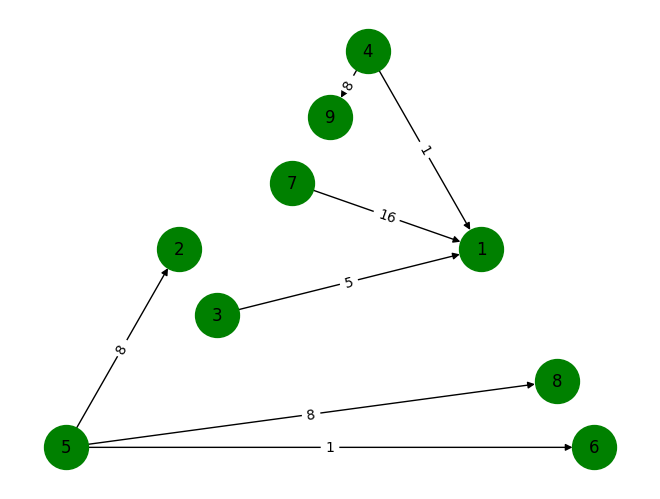

In [43]:
import random

def randomized_rounding_approximation(balances):
    """
    Minimize debts using randomized rounding approximation.
    :param balances: List of tuples representing balances (amount, person_number).
    :return: List of transactions to settle debts.
    """
    creditors = [(amount, person) for amount, person in balances if amount > 0]
    debtors = [(amount, person) for amount, person in balances if amount < 0]

    transactions = []

    while debtors:
        # Randomly select debtor and creditor
        debtor_idx = random.randint(0, len(debtors) - 1)
        creditor_idx = random.randint(0, len(creditors) - 1)

        debt, debtor = debtors[debtor_idx]
        credit, creditor = creditors[creditor_idx]

        # Determine transaction amount
        amount = min(-debt, credit)

        # Record the transaction
        transactions.append((creditor, debtor, amount))

        # Update balances
        debt += amount
        credit -= amount

        # Update creditor and debtor balances
        if credit == 0:
            creditors.pop(creditor_idx)
        else:
            creditors[creditor_idx] = (credit, creditor)

        if debt == 0:
            debtors.pop(debtor_idx)
        else:
            debtors[debtor_idx] = (debt, debtor)

    return transactions

# Example usage
set7 = SortedList(arr2)

transactions = randomized_rounding_approximation(set7)
print("Transactions:", transactions)
FinalTranny.append(len(transactions))
print("Total number of transactions: ", len(transactions))
# print("Total(also minimum) cash flow: ", sum2)

G = nx.DiGraph()
# G.add_nodes_from(people1)
# Add nodes and edges with the custom function
for (u, v, w) in transactions:
    if(w > 0):
      add_weighted_edge(G, u, v, w)

# Get positions for drawing and print the directed graph
pos = nx.planar_layout(G)
print_digraph(reorient_digraph(G), pos)

# Heuristics: Network Flow Approximation:


*   Approach: Model the debt settlement problem as a flow network, connecting debtors to creditors with edges representing possible transactions, and calculate the maximum flow to determine optimal transactions.
*   Pros: Provides optimal transaction minimization through precise flow calculations and is effective for complex debt structures.
*   Cons: Computationally expensive and harder to implement, especially for large groups, due to graph construction and max-flow algorithms.

The time complexity of the network_flow_approximation function is O(m^3 * n^2), where m is the number of debtors and n is the number of creditors in the balances list.

Transactions: [(3, 1, 5), (4, 1, 9), (7, 1, 8), (7, 2, 8), (5, 8, 8), (5, 9, 8), (5, 6, 1)]
Total number of transactions:  7


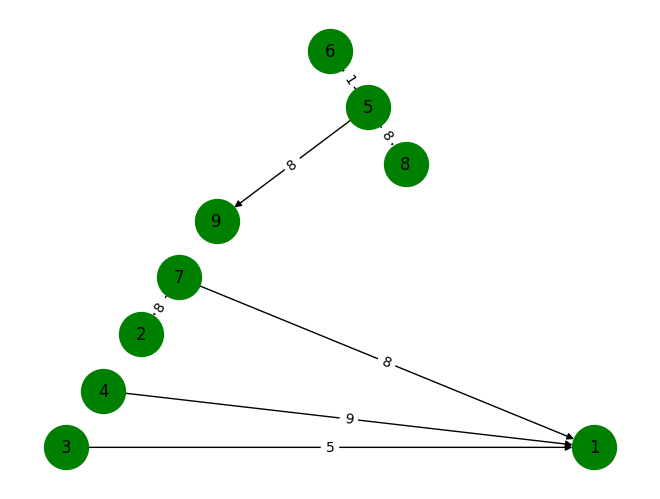

In [44]:
from collections import defaultdict, deque

def network_flow_approximation(balances):
    """
    Minimize debts using a network flow-based approximation.
    :param balances: List of tuples representing balances (amount, person_number).
    :return: List of transactions to settle debts.
    """
    creditors = [(amount, person) for amount, person in balances if amount > 0]
    debtors = [(amount, person) for amount, person in balances if amount < 0]

    # Build the graph
    graph = defaultdict(lambda: defaultdict(int))
    for debt, debtor in debtors:
        for credit, creditor in creditors:
            graph[debtor][creditor] = min(-debt, credit)

    # Compute the maximum flow
    def bfs(capacity, flow, source, sink):
        """Find an augmenting path using BFS."""
        parent = {}
        visited = set()
        queue = deque([source])
        visited.add(source)

        while queue:
            node = queue.popleft()
            for neighbor, cap in capacity[node].items():
                if neighbor not in visited and cap - flow[node][neighbor] > 0:
                    parent[neighbor] = node
                    if neighbor == sink:
                        return parent
                    queue.append(neighbor)
                    visited.add(neighbor)

        return None

    def max_flow(capacity, source, sink):
        """Compute the maximum flow using the Edmonds-Karp algorithm."""
        flow = defaultdict(lambda: defaultdict(int))
        max_flow_value = 0

        while True:
            parent = bfs(capacity, flow, source, sink)
            if not parent:
                break

            # Find the maximum flow through the path
            path_flow = float('Inf')
            s = sink
            while s != source:
                path_flow = min(path_flow, capacity[parent[s]][s] - flow[parent[s]][s])
                s = parent[s]

            # Update the flow along the path
            v = sink
            while v != source:
                u = parent[v]
                flow[u][v] += path_flow
                flow[v][u] -= path_flow
                v = parent[v]

            max_flow_value += path_flow

        return flow, max_flow_value

    # Add a super-source and super-sink
    source, sink = 'source', 'sink'
    for debt, debtor in debtors:
        graph[source][debtor] = -debt
    for credit, creditor in creditors:
        graph[creditor][sink] = credit

    # Run max flow algorithm
    flow, _ = max_flow(graph, source, sink)

    # Extract transactions from the flow
    transactions = []
    for debtor in debtors:
        for creditor in creditors:
            if flow[debtor[1]][creditor[1]] > 0:
                transactions.append((creditor[1], debtor[1], flow[debtor[1]][creditor[1]]))

    return transactions

# Example usage
set9 = SortedList(arr2)

transactions = network_flow_approximation(set9)
print("Transactions:", transactions)
FinalTranny.append(len(transactions))

print("Total number of transactions: ", len(transactions))
# print("Total(also minimum) cash flow: ", sum2)

G = nx.DiGraph()
# G.add_nodes_from(people1)
# Add nodes and edges with the custom function
for (u, v, w) in transactions:
    if(w > 0):
      add_weighted_edge(G, u, v, w)

# Get positions for drawing and print the directed graph
pos = nx.planar_layout(G)
print_digraph(reorient_digraph(G), pos)

# Heuristics: LP using pulp Approximation:
Variation for the linear programming solution. Uses pulp. Tries minimising the number of transactions.
*   Approach: Formulate the debt settlement problem as a linear programming optimization to minimize the number of transactions while satisfying all balances.
*   Pros: Guarantees precise solutions with closely optimal transactions.
*   Cons: Requires solving a computationally expensive linear program, limiting scalability for larger groups.

The time complexity of the minTX_lp function is O((m * n)^3)

Transactions: [(4, 1, 9.0), (7, 1, 13.0), (5, 2, 8.0), (5, 8, 8.0), (3, 9, 5.0), (7, 9, 2.0), (5, 9, 1.0), (7, 6, 1.0)]
Total number of transactions:  8


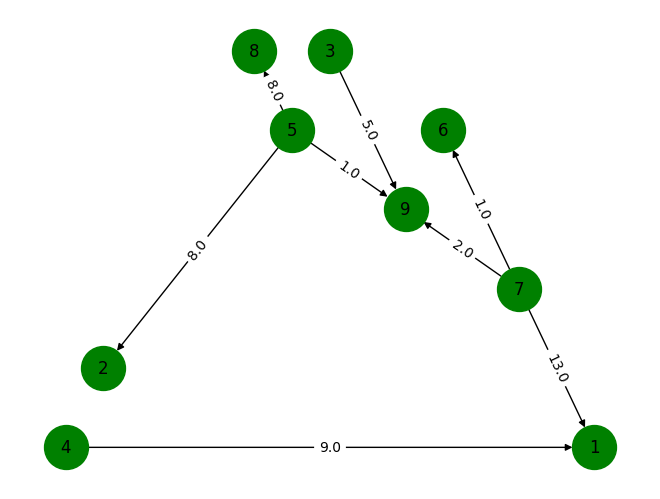

In [45]:
import pulp

def minTX_lp(balances):
    """
    MinTX LP Algorithm to minimize the number of transactions needed to settle debts.
    :param balances: List of tuples representing balances (amount, person_number).
    :return: List of transactions to settle debts.
    """
    # Separate debtors and creditors
    creditors = [(amount, person) for amount, person in balances if amount > 0]
    debtors = [(amount, person) for amount, person in balances if amount < 0]

    # Create a linear programming problem
    prob = pulp.LpProblem("Minimize_Transactions", pulp.LpMinimize)

    # Create variables for the transactions between debtors and creditors
    transaction_vars = {}
    for debtor_amount, debtor in debtors:
        for creditor_amount, creditor in creditors:
            var_name = f"t_{debtor}_{creditor}"
            transaction_vars[(debtor, creditor)] = pulp.LpVariable(var_name, lowBound=0, cat="Continuous")

    # Objective: Minimize the sum of all transactions
    prob += pulp.lpSum(transaction_vars.values()), "Minimize Transactions"

    # Constraints: Ensure that each debtor pays their full debt and each creditor receives their full credit
    for debtor_amount, debtor in debtors:
        prob += pulp.lpSum(transaction_vars[(debtor, creditor)] for _, creditor in creditors) == -debtor_amount, f"Debtor {debtor} Balance"

    for creditor_amount, creditor in creditors:
        prob += pulp.lpSum(transaction_vars[(debtor, creditor)] for debtor_amount, debtor in debtors) == creditor_amount, f"Creditor {creditor} Balance"

    # Solve the linear program
    prob.solve()

    # Extract the transactions from the solution
    transactions = []
    for (debtor, creditor), var in transaction_vars.items():
        if var.varValue > 0:
            transactions.append((creditor, debtor, var.varValue))

    return transactions


set10 = SortedList(arr2)

transactions = minTX_lp(set10)
print("Transactions:", transactions)
FinalTranny.append(len(transactions))
print("Total number of transactions: ", len(transactions))
# print("Total(also minimum) cash flow: ", sum2)

G = nx.DiGraph()
# G.add_nodes_from(people1)
# Add nodes and edges with the custom function
for (u, v, w) in transactions:
    if(w > 0):
      add_weighted_edge(G, u, v, w)

# Get positions for drawing and print the directed graph
pos = nx.planar_layout(G)
print_digraph(reorient_digraph(G), pos)

In [46]:
min_value = min(FinalTranny)
indices = [i for i in range(7) if FinalTranny[i] == min_value]
print("The minimal number of transactions possible will be :", finMini)
print("The best algorithm for this problem is :")
print(FinalTranny)
for i in indices:
  print(nameList[i])
print("The minimum number of transactions using this is: ", min_value)

The minimal number of transactions possible will be : 6
The best algorithm for this problem is :
[6, 7, 7, 8, 7, 7, 8]
Greedy
The minimum number of transactions using this is:  6


In [47]:
def is_zero_sum(subset):
    sum1 = 0
    for x, y in subset:
        sum1 += x
    return sum1 == 0


def find_zero_sum_subsets(arr):
    zero_sum_subsets = []
    n = len(arr)

    # Generate all possible subsets
    for subset_size in range(1, n + 1):
        for subset in combinations(arr, subset_size):
            if is_zero_sum(subset):
                zero_sum_subsets.append(subset)
    return zero_sum_subsets


def max_zero_sum_partition1(arr):
    memo = {}
    n = len(arr)
    heap = []

    # Initial state: No partitions, all elements remaining
    heapq.heappush(heap, (0, 0, tuple(arr), []))
    best_partition = []

    while heap:
        # Pop the state with the lowest cost (A* prioritizes lowest cost)
        cost, zero_sum_count, remaining, current_partition = heapq.heappop(heap)

        # If this state has been visited, skip it
        if remaining in memo and memo[remaining] >= zero_sum_count:
            continue

        # Memoize the current state
        memo[remaining] = zero_sum_count

        # If no elements are remaining, we've found a valid partition
        if not remaining:
            if zero_sum_count > len(best_partition):
                best_partition = current_partition
            continue

        # Generate all possible zero-sum subsets from the remaining elements
        zero_sum_subsets = find_zero_sum_subsets(remaining)

        for subset in zero_sum_subsets:
            # Remove the subset elements from remaining and create the next state
            new_remaining = list(remaining)
            for el in subset:
                new_remaining.remove(el)
            new_remaining = tuple(new_remaining)

            # New partition includes this subset
            new_partition = current_partition + [subset]

            # Add the new state to the heap with updated cost and heuristic
            heapq.heappush(heap, (len(new_remaining), zero_sum_count + 1, new_remaining, new_partition))

    return n-len(best_partition)
def max_zero_sum_partition5(arr):
    memo = {}
    n = len(arr)
    heap = []

    # Initial state: No partitions, all elements remaining
    heapq.heappush(heap, (0, 0, tuple(arr), []))
    best_partition = []

    while heap:
        # Pop the state with the lowest cost (A* prioritizes lowest cost)
        cost, zero_sum_count, remaining, current_partition = heapq.heappop(heap)

        # If this state has been visited, skip it
        if remaining in memo and memo[remaining] >= zero_sum_count:
            continue

        # Memoize the current state
        memo[remaining] = zero_sum_count

        # If no elements are remaining, we've found a valid partition
        if not remaining:
            if zero_sum_count > len(best_partition):
                best_partition = current_partition
            continue

        # Generate all possible zero-sum subsets from the remaining elements
        zero_sum_subsets = find_zero_sum_subsets(remaining)

        for subset in zero_sum_subsets:
            # Remove the subset elements from remaining and create the next state
            new_remaining = list(remaining)
            for el in subset:
                new_remaining.remove(el)
            new_remaining = tuple(new_remaining)

            # New partition includes this subset
            new_partition = current_partition + [subset]

            # Add the new state to the heap with updated cost and heuristic
            heapq.heappush(heap, (len(new_remaining), zero_sum_count + 1, new_remaining, new_partition))

    a = []
    for _ in range(n-len(best_partition)):
      a.append(1)
    return a

def maxpair(balances):
  balance = SortedList(balances)
  tranny2 = []
  while len(balance) > 1:
      top = balance[0]  # Smallest element
      bottom = balance[-1]  # Largest element
      balance.pop(0)  # Remove the smallest element
      balance.pop(-1)  # Remove the largest elemen
      tranny2.append([bottom[1], top[1], min(abs(bottom[0]), abs(top[0]))])
      if abs(bottom[0]) > abs(top[0]):
          balance.add((abs(bottom[0]) - abs(top[0]), bottom[1]))
      elif abs(bottom[0]) < abs(top[0]):
          balance.add((abs(bottom[0]) - abs(top[0]), top[1]))
  return tranny2

In [48]:
import random
import numpy as np
from prettytable import PrettyTable

def gen_cases(n, m):
    mp = {i: 0 for i in range(n)}
    for _ in range(m):
        i, j = random.sample(range(n), 2)
        w = random.randint(1, 10)
        mp[i] += w
        mp[j] -= w
    balance_array = [mp[i] for i in range(n)]

    return balance_array

heuristics = {
    "Maximum Pair Match": maxpair,
    "Linear Prog": linear_programming_approximation,
    "Closest Match": closest_match_heuristic,
    "Auction Based": auction_based_approximation,
    "Randomised Rounding": randomized_rounding_approximation,
    "Network Flow": network_flow_approximation,
    "LP using Pulp": minTX_lp,
}

def calculate_and_display(num_test_cases=10, n=8, m=15):
    """
    Calculate deviations for heuristic solutions against brute force
    and display the results in a table for a configurable number of test cases.

    :param num_test_cases: Number of random test cases to generate and analyze.
    """
    deviations_by_heuristic = {name: [] for name in heuristics.keys()}
    test_case_results = []

    # Generate specified number of test cases
    for _ in range(num_test_cases):
        balances = gen_cases(n, m)
        arrfin = []
        ind = 1
        for i in balances:
            arrfin.append((i, ind))
            ind += 1

        brute_force_tx = max_zero_sum_partition1(arrfin)

        # Collect deviations for this test case
        test_case_result = {}
        test_case_result["Brute Force"] = brute_force_tx
        for name, heuristic in heuristics.items():
            heuristic_tx = len(heuristic(arrfin))
            deviation = abs(heuristic_tx - brute_force_tx)
            deviations_by_heuristic[name].append(deviation)
            test_case_result[name] = deviation
        test_case_results.append(test_case_result)

    # Create the table
    table = PrettyTable()
    table.field_names = ["Heuristic"] + [f"Test Case {i+1}" for i in range(num_test_cases)] + ["Std Dev"]

    # Add rows for each heuristic
    for name, deviations in deviations_by_heuristic.items():
        row = [name] + deviations + [f"{np.std(deviations):.2f}"]
        table.add_row(row)

    # Print the table
    print(table)

def calculate_and_display2(num_test_cases=10, n=8, m=15):
    """
    Calculates and displays a table comparing heuristic solutions against brute force
    for a configurable number of test cases.

    :param num_test_cases: Number of random test cases to generate and analyze.
    """
    heuristic_results = {name: [] for name in heuristics.keys()}
    brute_force_results = []
    deviations_by_heuristic = {name: [] for name in heuristics.keys()}

    # Generate specified number of test cases
    for _ in range(num_test_cases):
        balances = gen_cases(n, m)
        arrfin1 = []
        ind = 1
        for i in balances:
            arrfin1.append((i, ind))
            ind += 1

        arrfin = SortedList(arrfin1)
        brute_force_tx = max_zero_sum_partition1(arrfin)
        brute_force_results.append(brute_force_tx)

        for name, heuristic in heuristics.items():
            heuristic_tx = len(heuristic(arrfin))
            heuristic_results[name].append(heuristic_tx)
            deviations_by_heuristic[name].append(abs(heuristic_tx - brute_force_tx))

    # Create the table
    table = PrettyTable()
    table.field_names = ["Heuristic"] + [f"Test Case {i+1}" for i in range(num_test_cases)] + ["Deviation"]

    # Add rows for each heuristic
    for name in heuristics.keys():
        transactions = heuristic_results[name]
        deviation = f"{np.mean(deviations_by_heuristic[name]):.2f}"
        table.add_row([name] + transactions + [deviation])

    # Print brute force results as reference
    table.add_row(["Brute Force"] + brute_force_results + ["0"])

    print(table)

# Run the program
calculate_and_display2(100, 7, 18)

+---------------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+-----------


## References

- Verhoeff, Tom. "Settling multiple debts efficiently: An invitation to computing science." _Informatics in Education-An International Journal_ 3.1 (2004): 105-126. [Direct link](https://www.researchgate.net/profile/Tom_Verhoeff/publication/220396130_Settling_Multiple_Debts_Efficiently_An_Invitation_to_Computing_Science/links/00463519f239f8a553000000/Settling-Multiple-Debts-Efficiently-An-Invitation-to-Computing-Science.pdf)
